### ANSWER FOR TASK QUESTIONS IN THE END

In [229]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.inspection import permutation_importance
from sklearn.metrics import PrecisionRecallDisplay

%matplotlib inline

In [3]:
data = pd.read_csv(r"C:\Users\drang\Downloads\online job\Fraud.csv")

In [4]:
df=data
df.tail()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0
6362619,743,CASH_OUT,850002.52,C1280323807,850002.52,0.0,C873221189,6510099.11,7360101.63,1,0


# Data preprocessing
## examining data


In [5]:
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [6]:
df["type"].value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

In [7]:
df["nameOrig"]=df["nameOrig"].astype('category')
df["nameOrigcode"]=df["nameOrig"].cat.codes   # uniques= 6353307 outof 6.6m

In [8]:
df["nameDest"]=df["nameDest"].astype('category')
df["nameDestcode"]=df["nameDest"].cat.codes

In [9]:
df["type"]=df["type"].astype('category')

In [10]:
df["typecode"]=df["type"].cat.codes
#['CASH_IN', 'CASH_OUT', 'DEBIT', 'PAYMENT', 'TRANSFER'] 01234 order

In [11]:
#NO NULL VALUES
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
nameOrigcode      0
nameDestcode      0
typecode          0
dtype: int64

In [12]:
#fraud counts
cc = df["isFraud"].value_counts()
print(f"fraud counts \n {cc}")
ratiof = cc[1]/len(df)
print(f"ratio of fraud in given dataset {round(ratiof,5)}%")

fraud counts 
 0    6354407
1       8213
Name: isFraud, dtype: int64
ratio of fraud in given dataset 0.00129%


In [13]:
#flagged fraud counts
cf = df["isFlaggedFraud"].value_counts()
print(f"flagged fraud counts \n {cf}")
ratiof = cf[1]/len(df)
print(f"ratio of flagged fraud in given dataset {round(ratiof,5)}%")

flagged fraud counts 
 0    6362604
1         16
Name: isFlaggedFraud, dtype: int64
ratio of flagged fraud in given dataset 0.0%


In [14]:
#transaction amount stats
df["amount"].describe()

count    6.362620e+06
mean     1.798619e+05
std      6.038582e+05
min      0.000000e+00
25%      1.338957e+04
50%      7.487194e+04
75%      2.087215e+05
max      9.244552e+07
Name: amount, dtype: float64

# Old manual way for fraud detection


In [15]:
df.groupby('isFraud').mean()


C:\Users\drang\AppData\Local\Temp\ipykernel_16980\168325711.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('isFraud').mean()


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,nameOrigcode,nameDestcode,typecode
isFraud,,,,,,,,,,
0,243.235663,1.781970e+05,8.328287e+05,855970.228109,1.101421e+06,1.224926e+06,0.000000,3.176709e+06,747019.445822,1.713139
1,368.413856,1.467967e+06,1.649668e+06,192392.631836,5.442496e+05,1.279708e+06,0.001948,3.153018e+06,288084.538658,2.496530


In [16]:
df['manualfraud'] = np.where(np.logical_and(df["amount"]> 1.467967e+06,  df["typecode"]>2.4), 1, 0)
#as these 2 variable supposed to influence the model most analytically

In [17]:
print("manualfraud count",df['manualfraud'].sum())
print("out of 72185 fraud detect, 1058 is true positive")
pd.crosstab(df.isFraud, df.manualfraud, rownames=['isFraud'], colnames=['manualfraud'])


manualfraud count 73243
out of 72185 fraud detect, 1058 is true positive


manualfraud,0,1
isFraud,,
0,6282222,72185
1,7155,1058


# Feature Engineering


In [126]:
#creating new ratio variables 

#for origin acc old balance to amount
df["orgintoamt"] = df["amount"]/df["oldbalanceOrg"]

# fill nulls with ratio 1
df["orgintoamt"].fillna(1, inplace=True) 

#treating infinite values 
ins = np.where(df['orgintoamt']==np.inf)
df['orgintoamt'].iloc[ins] = 0


#for amount to new orign balance
df["amttodest"] = df["amount"]/df["newbalanceOrig"]
df["amttodest"].fillna(1, inplace=True)
ins2 = np.where(df['amttodest']==np.inf)
df['amttodest'].iloc[ins2] = 0

C:\Users\drang\AppData\Local\Temp\ipykernel_16980\3149333291.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['orgintoamt'].iloc[ins] = 0
C:\Users\drang\AppData\Local\Temp\ipykernel_16980\3149333291.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['amttodest'].iloc[ins2] = 0


In [ ]:
"""find null and inf by
np.all(np.isfinite(df['orgintoamt']))
np.any(np.isnan(df['orgintoamt']))"""

In [19]:
#Differences between old and new balances
#origin
df["origindiff"] = df["newbalanceOrig"]-df["oldbalanceDest"]

#destination
df["destdiff"] = df["newbalanceOrig"]-df["oldbalanceDest"]



In [20]:
groupedbyorig = (df["nameOrig"].value_counts()[df["nameOrig"]]).reset_index(drop=True)
groupedbydest = (df["nameDest"].value_counts()[df["nameDest"]]).reset_index(drop=True)

In [21]:
#average transaction amount by origin acc = amt/ N transactions of origin
df["avgtransorigin"] = df["amount"] / groupedbyorig

#average transaction amount by dest acc = amt/ N transactions of Dest
df["avgtransdest"] = df["amount"] / groupedbydest

In [24]:
#Evaluating Columns
ecols = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
        'oldbalanceDest', 'newbalanceDest', 'typecode', 'orgintoamt', 'amttodest',
       'origindiff', 'destdiff', 'avgtransorigin', 'avgtransdest',
       'nameOrigcode', 'nameDestcode']
df[ecols]

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,typecode,orgintoamt,amttodest,origindiff,destdiff,avgtransorigin,avgtransdest,nameOrigcode,nameDestcode
0,1,9839.64,170136.00,160296.36,0.00,0.00,3,0.057834,0.061384,160296.36,160296.36,9839.64,9.839640e+03,757869,1662094
1,1,1864.28,21249.00,19384.72,0.00,0.00,3,0.087735,0.096173,19384.72,19384.72,1864.28,1.864280e+03,2188998,1733924
2,1,181.00,181.00,0.00,0.00,0.00,4,1.000000,inf,0.00,0.00,181.00,4.113636e+00,1002156,439685
3,1,181.00,181.00,0.00,21182.00,0.00,1,1.000000,inf,-21182.00,-21182.00,181.00,4.414634e+00,5828262,391696
4,1,11668.14,41554.00,29885.86,0.00,0.00,3,0.280795,0.390423,29885.86,29885.86,11668.14,1.166814e+04,3445981,828919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,339682.13,339682.13,0.00,0.00,339682.13,1,1.000000,inf,0.00,0.00,339682.13,1.698411e+05,5651847,505863
6362616,743,6311409.28,6311409.28,0.00,0.00,0.00,4,1.000000,inf,0.00,0.00,6311409.28,6.311409e+06,1737278,260949
6362617,743,6311409.28,6311409.28,0.00,68488.84,6379898.11,1,1.000000,inf,-68488.84,-68488.84,6311409.28,2.103803e+06,533958,108224
6362618,743,850002.52,850002.52,0.00,0.00,0.00,4,1.000000,inf,0.00,0.00,850002.52,8.500025e+05,2252932,319713


In [25]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
nameOrigcode      0
nameDestcode      0
typecode          0
manualfraud       0
orgintoamt        0
amttodest         0
origindiff        0
destdiff          0
avgtransorigin    0
avgtransdest      0
dtype: int64

# EDA

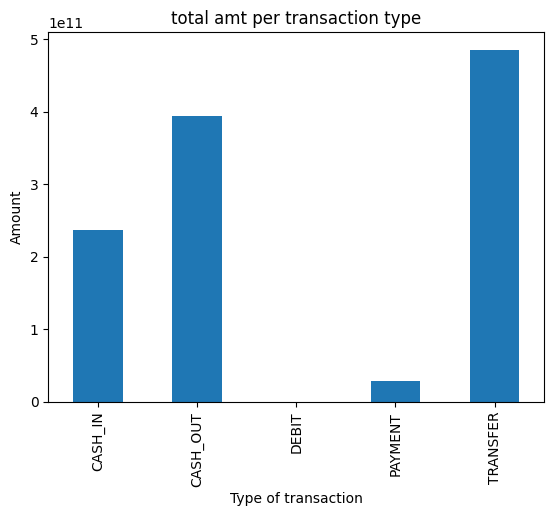

In [26]:
a = df.groupby('type').amount.sum()
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
a.plot(kind='bar')
ax1.set_title("total amt per transaction type")
ax1.set_xlabel('Type of transaction')
ax1.set_ylabel('Amount');

In [79]:
def plot_data(X, y): # amount to type
    plt.scatter(X[y == 0, 2], X[y == 0, 1], label="noFraud #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X[y == 1, 2], X[y == 1, 1], label="Fraud #1", alpha=0.5, linewidth=0.15, c='r')
    plt.legend()
    plt.xlabel("amount")
    return plt.show()

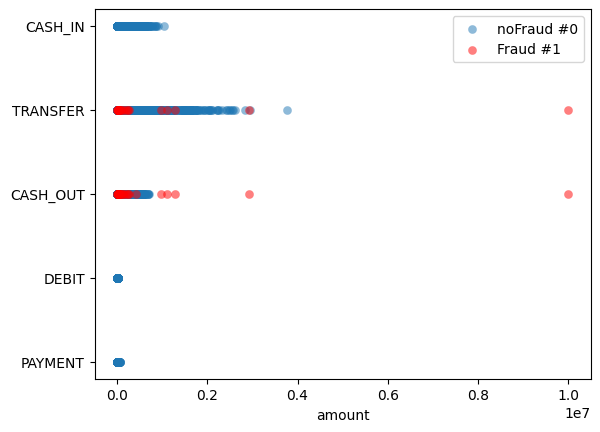

In [81]:
X = df.iloc[:10000, :].values
y = df.iloc[:10000,:].isFraud.values
plot_data(X,y)
#some pattern around some amount number

<AxesSubplot: >

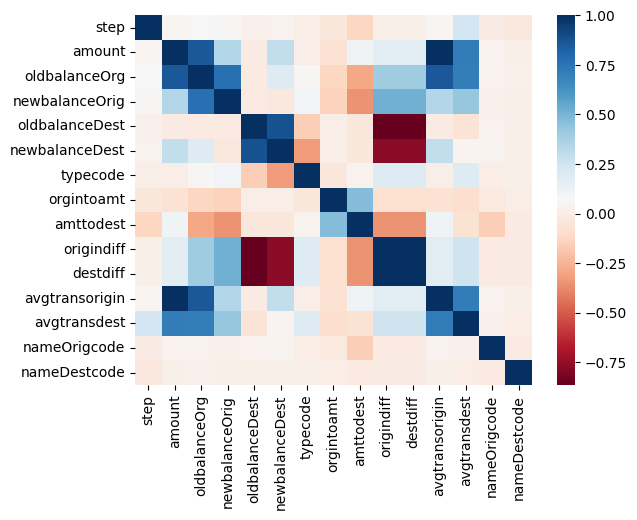

In [84]:
fraud = df[ecols].loc[df.isFraud == 1]

sns.heatmap(fraud.corr(),cmap='RdBu')


In [ ]:

# TRANSFER and CASH_OUT are two most used mode of transaction for frauds
# if want so we can filter just these 2 mode of transaction like X = df.loc[(df.PaymentType == 'TRANSFER') | (df.PaymentType == 'CASH_OUT')]


In [127]:
#scaling features
scaler = MinMaxScaler()
dfs = scaler.fit_transform(df[ecols])

In [145]:
X = dfs
y = df["isFraud"].reset_index(drop=True).values

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state = 53)

lof = LocalOutlierFactor()
yhat = lof.fit_predict(X_train)
# select all rows that are not outliers
mask = yhat != -1
X_train, y_train = X_train[mask, :], y_train[mask]

In [150]:
train_X.shape


(5090096, 15)

# ML Train and Predict

## RANDOM FOREST CLASSIFIER


In [152]:
clf = RandomForestClassifier(n_estimators=15)
probabilities = clf.fit(train_X, train_y.ravel()).predict(test_X)

In [186]:
# ACCURACY METRICS
def acc_mets(test_y, probabilities):
    from sklearn.metrics import average_precision_score, f1_score, accuracy_score
    print("average_precision",average_precision_score(test_y,probabilities))
    print("f1_score", f1_score(test_y,probabilities) )
    print("accuracy_score", accuracy_score(test_y,probabilities))

In [187]:
def report(test_y, probabilities):
    print('ROC Score:')
    print(roc_auc_score(test_y, probabilities))
    print('Classifcation report:\n', classification_report(test_y, probabilities))
    conf_mat = confusion_matrix(y_true=test_y, y_pred=probabilities)
    print('Confusion matrix:\n', conf_mat)

#correctly found frauds =1240
#correct fraud didnot predicted by model = 22
#false positive(wrongly predicted as frauds) = 419

In [188]:
def displaycurve(test_y, probabilities):
    # import the methods for curve
    from sklearn.metrics import precision_recall_curve, average_precision_score
    precision_cur = precision_recall_curve(test_y, probabilities)
    precision_cur
    display = PrecisionRecallDisplay.from_estimator(
        clf, test_X, test_y, name="RandomForest"
    )
    _ = display.ax_.set_title("2-class Precision-Recall curve")

RANDOMFOREST
average_precision 0.7347376564011852
f1_score 0.8490243067442657
accuracy_score 0.9996534446501598
ROC Score:
0.8737104523742968
Classifcation report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270865
           1       0.98      0.75      0.85      1659

    accuracy                           1.00   1272524
   macro avg       0.99      0.87      0.92   1272524
weighted avg       1.00      1.00      1.00   1272524

Confusion matrix:
 [[1270843      22]
 [    419    1240]]


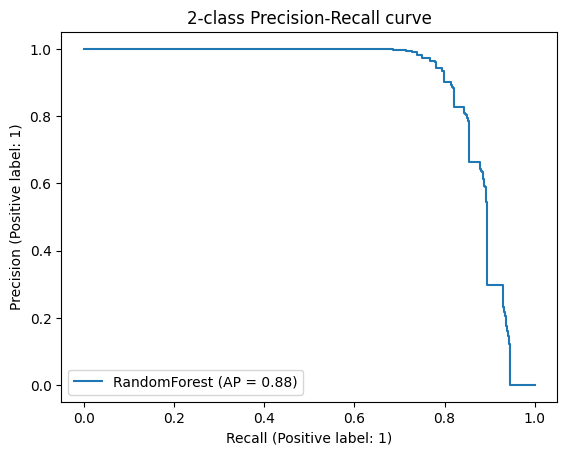

In [191]:
print("RANDOMFOREST")
acc_mets(test_y, probabilities)
report(test_y, probabilities)
displaycurve(test_y, probabilities)

# LOGREG


In [193]:
model = LogisticRegression(solver='liblinear')
model.fit(train_X, train_y)

# Get model performance metrics
predicted = model.predict(test_X)


C:\Users\drang\anaconda3\envs\CV0\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

average_precision 0.09228081740368593
f1_score 0.1863220247711362
accuracy_score 0.998812596068915
ROC Score:
0.5521300074585993
Classifcation report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270865
           1       0.87      0.10      0.19      1659

    accuracy                           1.00   1272524
   macro avg       0.94      0.55      0.59   1272524
weighted avg       1.00      1.00      1.00   1272524

Confusion matrix:
 [[1270840      25]
 [   1486     173]]


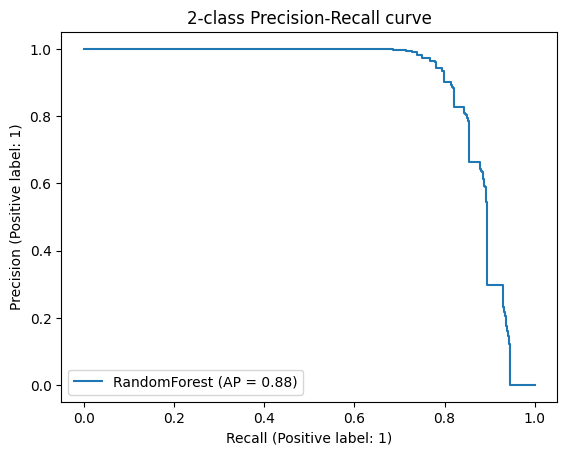

In [194]:
acc_mets(test_y, predicted)
report(test_y, predicted)
displaycurve(test_y, predicted)

# DECISION TREE

In [197]:
clf = tree.DecisionTreeClassifier()
clf.fit(train_X, train_y)



DecisionTreeClassifier()

average_precision 0.7223737941249768
f1_score 0.8497251069028712
accuracy_score 0.9996133668205864
ROC Score:
0.9191403219224796
Classifcation report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270865
           1       0.86      0.84      0.85      1659

    accuracy                           1.00   1272524
   macro avg       0.93      0.92      0.92   1272524
weighted avg       1.00      1.00      1.00   1272524

Confusion matrix:
 [[1270641     224]
 [    268    1391]]


[Text(0.975111380054811, 0.9888888888888889, 'X[0] <= 0.967\ngini = 0.003\nsamples = 5090096\nvalue = [5083542, 6554]'),
 Text(0.9742677651650081, 0.9666666666666667, 'X[12] <= 0.239\ngini = 0.002\nsamples = 5089852\nvalue = [5083542, 6310]'),
 Text(0.9510663749994247, 0.9444444444444444, 'X[12] <= 0.033\ngini = 0.002\nsamples = 5089371\nvalue = [5083345, 6026]'),
 Text(0.9071944393376663, 0.9222222222222223, 'X[12] <= 0.01\ngini = 0.002\nsamples = 5075221\nvalue = [5070379, 4842]'),
 Text(0.8538476469975935, 0.9, 'X[6] <= 0.875\ngini = 0.001\nsamples = 4997780\nvalue = [4994204, 3576]'),
 Text(0.8084644335079995, 0.8777777777777778, 'X[11] <= 0.013\ngini = 0.001\nsamples = 4618362\nvalue = [4616210, 2152]'),
 Text(0.7916864925037139, 0.8555555555555555, 'X[11] <= 0.01\ngini = 0.001\nsamples = 4617992\nvalue = [4616081, 1911]'),
 Text(0.7606614551645511, 0.8333333333333334, 'X[11] <= 0.008\ngini = 0.001\nsamples = 4617494\nvalue = [4615690, 1804]'),
 Text(0.7011422251556337, 0.81111111

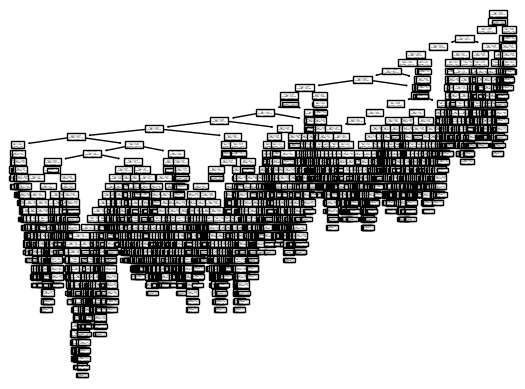

In [201]:
predicted = clf.predict(test_X)

acc_mets(test_y, predicted)
report(test_y, predicted)
displaycurve(test_y, predicted)
#tree plotting
tree.plot_tree(clf)

In [220]:
#display how decisions split
import pydot

from six import StringIO
dot_data = StringIO() 
from sklearn.tree import export_graphviz

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

export_graphviz(
clf,
out_file=r"C:\Users\drang\fraud_tree.dot",
feature_names=df[ecols].columns,
rounded=True,
filled=True
)

export_graphviz(clf, out_file=dot_data)
graph = pydot.graph_from_dot_data(dot_data.getvalue())
graph[0].write_pdf("fraud.pdf")


In [222]:
from IPython.display import IFrame
IFrame("fraud.pdf", width=1200, height=700)

# GradientBoostingClassifier

In [226]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=53).fit(train_X, train_y)

average_precision 0.0545859791731457
f1_score 0.13882863340563992
accuracy_score 0.9987520864046572
ROC Score:
0.5385550306282707
Classifcation report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270865
           1       0.69      0.08      0.14      1659

    accuracy                           1.00   1272524
   macro avg       0.85      0.54      0.57   1272524
weighted avg       1.00      1.00      1.00   1272524

Confusion matrix:
 [[1270808      57]
 [   1531     128]]


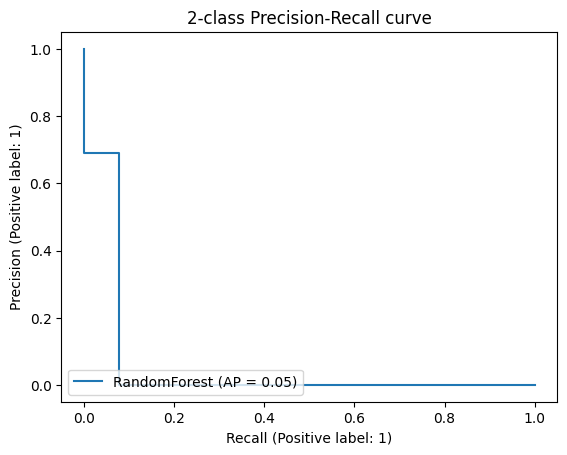

In [227]:
predicted = clf.predict(test_X)

acc_mets(test_y, predicted)
report(test_y, predicted)
displaycurve(test_y, predicted)


# Feature Selection/ Importance


In [245]:
# Tree based
from sklearn.feature_selection import SelectPercentile, chi2, f_classif
y = df["isFraud"]
selc = SelectPercentile(f_classif, percentile=90)
sel=selc.fit_transform(df[ecols], y)
columns = np.asarray(df[ecols].columns.values)
support = np.asarray(selc.get_support())
columns_with_support = columns[support]
print("90th percentile important feature using F ANOVA test",columns_with_support)

90th percentile important feature using F ANOVA test ['step' 'amount' 'oldbalanceOrg' 'newbalanceOrig' 'oldbalanceDest'
 'newbalanceDest' 'typecode' 'orgintoamt' 'origindiff' 'destdiff'
 'avgtransorigin' 'avgtransdest' 'nameDestcode']


In [240]:
# TREE IMPORTANCE
clf = RandomForestClassifier(n_estimators=15)
clf = clf.fit(train_X, train_y.ravel())

result = permutation_importance(clf, train_X, train_y, n_repeats=10, random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5




'# TREE IMPORTANCE\nclf = RandomForestClassifier(n_estimators=15)\nclf = clf.fit(train_X, train_y.ravel())\n\nresult = permutation_importance(clf, train_X, train_y, n_repeats=10, random_state=42)\nperm_sorted_idx = result.importances_mean.argsort()\n\ntree_importance_sorted_idx = np.argsort(clf.feature_importances_)\ntree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5\n\nfig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))\nax1.barh(tree_indices, clf.feature_importances_[tree_importance_sorted_idx], height=0.7)\nax1.set_yticks(tree_indices)\nax1.set_yticklabels(df[ecols].feature_names[tree_importance_sorted_idx])\nax1.set_ylim((0, len(clf.feature_importances_)))\nax2.boxplot(\n    result.importances[perm_sorted_idx].T,\n    vert=False,\n    labels=data.feature_names[perm_sorted_idx],\n)\nfig.tight_layout()\nplt.show()'

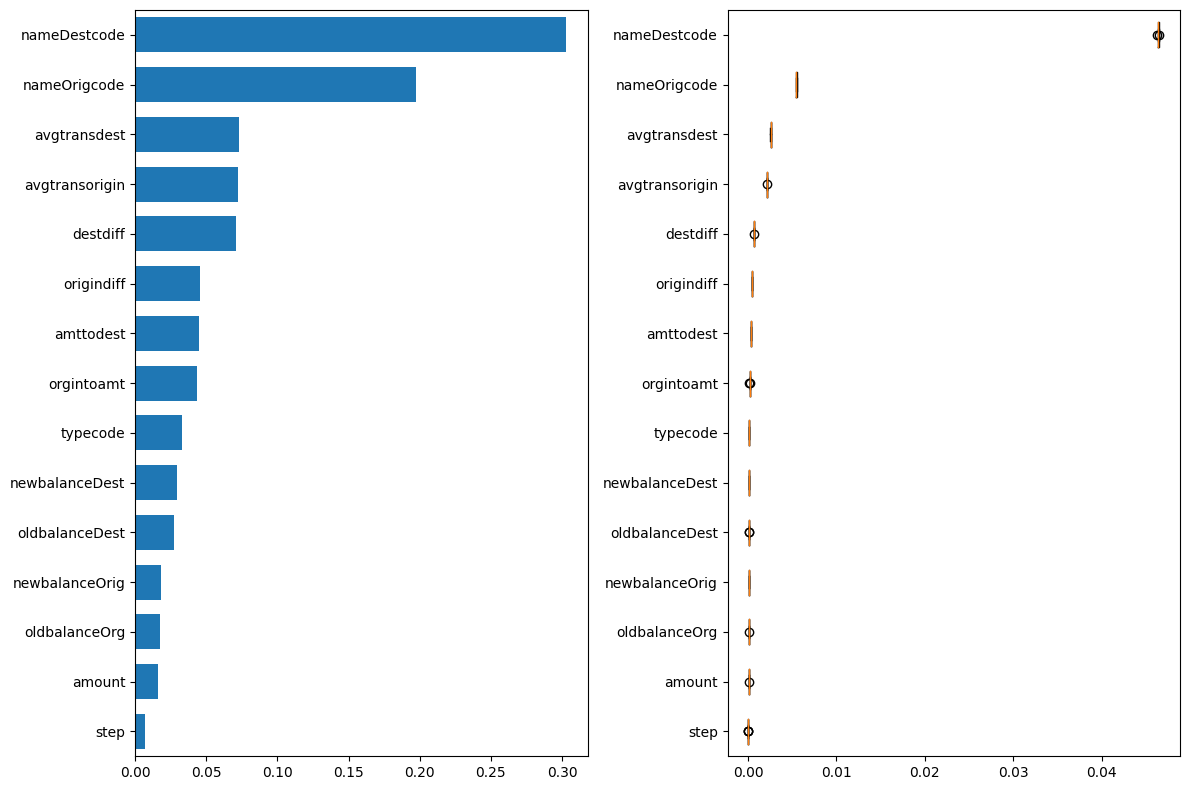

In [239]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices, clf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(df[ecols].iloc[tree_importance_sorted_idx])
ax1.set_ylim((0, len(clf.feature_importances_)))
ax2.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=df[ecols].iloc[perm_sorted_idx],
)
fig.tight_layout()
plt.show()

# 1. Data cleaning including missing values, outliers and multi-collinearity. 
missing values treated by pandas np.nan,
outliers cleaned used Localoutlier factor
multi-collinearity showed as heatmap , and randomforesttree's permutation_importance

# 2. Describe your fraud detection model in elaboration. 
started with manual old way of detection. As this is supervised binary classification problem, we tried ml models such as Decision Tree(best results), randomforest(moderate results), GBClassifier(worst result, as it overfits the data)-ensemble learning(stacks of small/moderate performing models). We got glimpse of fraud anamoly pattern while EDA, and created feature based on that findings and domain analytics.

# 3. How did you select variables to be included in the model?
Based on domain knowledge and insights gathered from EDA, also used feature selection method to show the importance of variables
and how their influence the models.

# 4. Demonstrate the performance of the model by using best set of tools. 
we used various metrics such as average_precision == accuracy_score, ROC Score(Receiver operating characteristic), Roc curve(to understand test accuracy visually, more area under curve = better), F1score( harmonic mean between precision and recall, 1 means best)

# 5. What are the key factors that predict fraudulent customer? 
key factors:
* from EDA2,TRANSFER and CASH_OUT are two most used mode of transaction for frauds
* from EDA3, the average transaction amount from the origin account and the average transaction amount from the destination account captures the fraud activities clearly.
* difference in old and new balance for each doesnot perform well as we failed to input the amount variable which captures unaccounted transaction.
* from EDA2, there exists a pattern where at particular levels of amount transaction, the fraud acitivities occurs.
* also, time step influence the fraud.

# 6. Do these factors make sense? If yes, How? If not, How not? 
yes, these factors make sense, detail above.

# 7. What kind of prevention should be adopted while company update its infrastructure?
* Running live fraud detection model is advisable and 
* if flagged as fraud double checking based on their cookie history authentication to block the transaction as fraud.
* also while updating, location based verification features can be added as extra security.

# 8. Assuming these actions have been implemented, how would you determine if they work?
* In the context of ML, we can only say a system is working with experimenting, without data we cant determine live fraud detection model.
* point 2 by understanding the behaviour of user search history using ml model.
* point 3 seems pretty obvious.
